# Wire RAG

<a href="https://colab.research.google.com/github/appunite/Wire-RAG/blob/main/main_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

Install dependencies and input keys on Colab

In [ ]:
!pip install haystack-ai pinecone-haystack sentence-transformers pinecone transformers

In [6]:
import os
import getpass
os.environ["PINECONE_API_KEY"] = getpass.getpass("pinecone api key")
os.environ["OPENAI_API_KEY"] = getpass.getpass("open ai api key")

Or load keys from .env file

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

## Populate Pinecone Database

### Scrape URLs

In [1]:
import aiohttp
import asyncio
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse
import nest_asyncio

# Apply the nest_asyncio patch to allow nested event loops in Jupyter
nest_asyncio.apply()

# Asynchronous URL fetching with retry logic
async def fetch_urls(url, session, retries=3):
    attempt = 0
    while attempt < retries:
        try:
            async with session.get(url, timeout=15) as response:
                if response.status != 200:
                    return set()  # Return an empty set if the page doesn't load
                text_content = await response.text()
                soup = BeautifulSoup(text_content, "html.parser")
                urls = set(
                    urljoin(url, link['href'])
                    for link in soup.find_all('a', href=True)
                    if urlparse(urljoin(url, link['href'])).scheme in ('http', 'https')
                )
                # if attempt > 0:
                #     print(f"Successfully fetched URL: {url} on attempt {attempt + 1}")
                return urls
        except (aiohttp.ClientError, asyncio.TimeoutError) as e:
            attempt += 1
            if attempt < retries:
                await asyncio.sleep(2 ** attempt)  # Exponential backoff
        except Exception as e:
            return set()

    print(f"Failed to fetch URL {url} after {retries} attempts.")
    return set()

# Check if URL should be allowed based on blacklist/whitelist mode
def is_url_allowed(url, black_list_data):
    url_list = black_list_data["list"]
    is_blacklist_mode = black_list_data["black_list"]

    parsed_url = urlparse(url)
    base_url = f"{parsed_url.scheme}://{parsed_url.netloc}"

    if is_blacklist_mode:
        # Blacklist mode: block URLs matching any blacklist entry
        for entry in url_list:
            entry_parsed = urlparse(entry)
            entry_base = f"{entry_parsed.scheme}://{entry_parsed.netloc}"
            if entry_base == base_url and url.startswith(entry):
                return False
            # Specifically check if the entry is a path that should be blocked
            if entry_parsed.netloc == parsed_url.netloc and urlparse(entry).path == parsed_url.path:
                return False
    else:
        # Whitelist mode: only allow URLs matching any whitelist entry
        return any(
            url.startswith(entry) or f"{urlparse(entry).scheme}://{urlparse(entry).netloc}" == base_url
            for entry in url_list
        )

    return True

# Asynchronous scraping with blacklist/whitelist and depth handling
async def scrape_urls(current_url, session, max_depth, current_depth=0, visited=None, list_data=None):
    if visited is None:
        visited = []

    if current_depth > max_depth:
        return visited  # Stop recursion if depth limit exceeded

    if not is_url_allowed(current_url, list_data):
        return visited  # Skip URL if not allowed

    visited.append(current_url)  # Store URL with its depth

    # Extract URLs from the current page
    urls = await fetch_urls(current_url, session)

    tasks = []
    for new_url in urls:
        if new_url not in visited and is_url_allowed(new_url, list_data):
            # Continue scraping at the next depth level if within depth limit
            if current_depth < max_depth:
                tasks.append(scrape_urls(new_url, session, max_depth, current_depth + 1, visited, list_data))

    # Await all the tasks concurrently
    await asyncio.gather(*tasks)
    return visited

# Entry point for asynchronous scraping
async def start_scraping(entry_url: str, depth: int, list_data=None) -> list[str]:
    async with aiohttp.ClientSession() as session:
        found_urls = await scrape_urls(entry_url, session, depth, list_data=list_data)
    return found_urls

In [2]:
starting_url = "https://docs.wire.com"
depth_limit = 2
whitelist = {"list": ["https://docs.wire.com"], "black_list": False}

scraped_urls = await start_scraping(starting_url, depth_limit, whitelist)

print(f"Total URLs found: {len(scraped_urls)}")

Total URLs found: 426


### Extract metadata and content

Prepare function to extract date based on regex patterns

In [4]:
import requests
import re
from datetime import datetime

# Regular expression patterns for various date formats
date_patterns = [
    r'\b\d{4}-\d{2}-\d{2}\b',            # Matches YYYY-MM-DD (e.g., 2024-09-20)
    r'\b\d{4}/\d{2}/\d{2}\b',            # Matches YYYY/MM/DD (e.g., 2024/09/20)
    r'\b\d{2}-\d{2}-\d{4}\b',            # Matches MM-DD-YYYY (e.g., 09-20-2024)
    r'\b\d{2}/\d{2}/\d{4}\b',            # Matches MM/DD/YYYY (e.g., 09/20/2024)
    r'\b\d{2}-\d{2}-\d{4}\b',            # Matches DD-MM-YYYY (e.g., 20-09-2024)
    r'\b\d{2}/\d{2}/\d{4}\b',            # Matches DD/MM/YYYY (e.g., 20/09/2024)
    r'\b\d{1,2}\s+[A-Za-z]+\s+\d{4}\b',  # Matches 20 September 2024
    r'\b[A-Za-z]+\s+\d{1,2},\s+\d{4}\b', # Matches September 20, 2024
    r'\b\d{1,2}\s+[A-Za-z]{3}\s+\d{4}\b', # Matches 20 Sep 2024 (short month)
    r'\b[A-Za-z]{3}\s+\d{1,2},\s+\d{4}\b', # Matches Sep 20, 2024 (short month)
    r'\b\d{1,2}-[A-Za-z]{3}-\d{4}\b',    # Matches 20-Sep-2024 (short month)
    r'\b[A-Za-z]{3}-\d{1,2}-\d{4}\b',    # Matches Sep-20-2024 (short month)
    r'\b[A-Za-z]+,\s+\d{1,2}\s+[A-Za-z]+\s+\d{4}\b', # Matches Friday, 20 September 2024 (with weekday)
    r'\b[A-Za-z]+,\s+[A-Za-z]+\s+\d{1,2},\s+\d{4}\b', # Matches Friday, September 20, 2024 (with weekday)
    r'\b\d{4}\.\d{2}\.\d{2}\b',          # Matches YYYY.MM.DD (e.g., 2024.09.20)
    r'\b\d{2}\.\d{2}\.\d{4}\b',          # Matches DD.MM.YYYY (e.g., 20.09.2024)
    r'\b\d{4}\s+[A-Za-z]{3}\s+\d{1,2}\b',# Matches 2024 Sep 20
    r'\b\d{4}\s+[A-Za-z]+\s+\d{1,2}\b',  # Matches 2024 September 20
    r'\b\d{1,2}\s+[A-Za-z]+,\s+\d{4}\b', # Matches 20 September, 2024 (comma after day)
    r'\b[A-Za-z]+\s+\d{1,2}\s+\d{4}\b'   # Matches September 20 2024 (no comma)
]


def find_all_dates_with_regex(text):
    """Search for all date matches using regex patterns."""
    dates = []
    for pattern in date_patterns:
        matches = re.findall(pattern, text)  # Find all matches for the pattern
        dates.extend(matches)
    return dates

def parse_date(date_str):
    """Convert a date string to a datetime object, trying different formats."""
    date_formats = [
        '%Y-%m-%d',        # Format: 2024-09-20
        '%Y/%m/%d',        # Format: 2024/09/20
        '%m-%d-%Y',        # Format: 09-20-2024
        '%m/%d/%Y',        # Format: 09/20/2024
        '%d-%m-%Y',        # Format: 20-09-2024
        '%d/%m/%Y',        # Format: 20/09/2024
        '%d %B %Y',        # Format: 20 September 2024
        '%B %d, %Y',       # Format: September 20, 2024
        '%d %b %Y',        # Format: 20 Sep 2024 (short month)
        '%b %d, %Y',       # Format: Sep 20, 2024 (short month)
        '%d-%b-%Y',        # Format: 20-Sep-2024 (short month)
        '%b-%d-%Y',        # Format: Sep-20-2024 (short month)
        '%A, %d %B %Y',    # Format: Friday, 20 September 2024 (with weekday)
        '%A, %B %d, %Y',   # Format: Friday, September 20, 2024 (with weekday)
        '%Y.%m.%d',        # Format: 2024.09.20
        '%d.%m.%Y',        # Format: 20.09.2024 (European format)
        '%Y %b %d',        # Format: 2024 Sep 20 (short month)
        '%Y %B %d',        # Format: 2024 September 20
        '%d %B, %Y',       # Format: 20 September, 2024 (comma after day)
        '%B %d %Y'         # Format: September 20 2024 (no comma)
    ]
    
    for date_format in date_formats:
        try:
            return datetime.strptime(date_str, date_format)
        except ValueError:
            pass
    return None

def get_latest_date(dates):
    """Return the latest valid date from a list of date strings."""
    parsed_dates = [parse_date(date) for date in dates]
    # Filter out any dates that couldn't be parsed and return the latest one
    valid_dates = [d for d in parsed_dates if d is not None]
    return max(valid_dates).strftime('%Y-%m-%d') if valid_dates else "None"

def extract_date(my_soup: BeautifulSoup) -> str:
    # Extract all text content to search for a date pattern
    text_content = my_soup.get_text(separator=' ', strip=True)

    # Use regex to find all dates in the page's text content
    dates = find_all_dates_with_regex(text_content)

    # Get the latest date found
    latest_date = get_latest_date(dates)
    return latest_date

Prepare function to extract content and metadata from a URL

In [5]:
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

def requests_retry_session(
    retries=3,
    backoff_factor=0.3,
    status_forcelist=(500, 502, 504),
    session=None,
):
    session = session or requests.Session()
    retry = Retry(
        total=retries,
        read=retries,
        connect=retries,
        backoff_factor=backoff_factor,
        status_forcelist=status_forcelist,
    )
    adapter = HTTPAdapter(max_retries=retry)
    session.mount('http://', adapter)
    session.mount('https://', adapter)
    return session


def extract_content_and_metadata(url: str) -> list[dict] | None:
    try:
        # Use retry session for robust requests
        session = requests_retry_session()
        response = session.get(url, timeout=10)

        # Check if request was successful
        response.raise_for_status()

        soup = BeautifulSoup(response.content, 'html.parser')
        title = soup.title.string if soup.title else "None"
        date = extract_date(soup)
        
        content_by_headline = {}
        current_header = None

        # Loop through the elements, keeping track of headlines and paragraphs
        for element in soup.find_all(['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'p', 'ul', 'ol']):
            if element.name.startswith('h'):
                # Headline
                current_header = element.get_text(strip=True)
                current_header = current_header.replace("\n", "")
                current_header = re.sub(r"\s+", " ", current_header)

            elif element.name in ['p', 'ul', 'ol'] and current_header:
                # Append the text under the last seen headline
                value = content_by_headline[current_header] if current_header in content_by_headline else ""
                content_by_headline[current_header] = f"{value} {element.get_text(strip=True).replace('\n', ' ')}"
    
        result_dicts = []
        for headline, content in content_by_headline.items():
            result_dicts.append({"content": content, "metadata": {"url": url, "title": title, "headline": headline, "date": date}})
            
        return result_dicts

    except requests.exceptions.RequestException as e:
        print(f"Error fetching {url}: {e}")
        return None


In [6]:
all_documents = []
for u in scraped_urls:
    all_documents += extract_content_and_metadata(u)
print(len(all_documents))

6631


To delete all records u need to `pip install "pinecone[grpc]"` and run the following code.

In [95]:
from pinecone.grpc import PineconeGRPC as Pinecone
from dotenv import load_dotenv
import os

load_dotenv()

# Uncomment the following line to delete all records
# Pinecone(api_key=os.getenv("PINECONE_API_KEY")).Index("default").delete(delete_all=True, namespace='default')

PineconeException: UNKNOWN:Error received from peer  {grpc_message:"Namespace not found", grpc_status:5, created_time:"2024-09-23T15:45:04.4877857+00:00"}

Initialize Pinecone Document Store

In [96]:
from haystack.components.preprocessors import DocumentSplitter, DocumentCleaner
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.joiners import DocumentJoiner
from haystack.components.writers import DocumentWriter
from haystack import Pipeline
from haystack import Document
from haystack_integrations.document_stores.pinecone import PineconeDocumentStore

document_store = PineconeDocumentStore(
    index="default",
    namespace="default",
    dimension=384,
    metric="cosine",
    spec={"serverless": {"region": "us-east-1", "cloud": "aws"}}
)

ready_list = []
for doc in all_documents:
    ready_list.append(Document(content=doc["content"], meta=doc["metadata"]))

Prepare pipeline components

In [97]:
document_joiner = DocumentJoiner()
document_cleaner = DocumentCleaner()
document_splitter = DocumentSplitter(split_by="word", split_length=200, split_overlap=20)
document_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
document_writer = DocumentWriter(document_store)

Create a pipeline to populate the Pinecone Document Store with test case documents

In [98]:
preprocessing_pipeline = Pipeline()

preprocessing_pipeline.add_component(instance=document_cleaner, name="document_cleaner")
preprocessing_pipeline.add_component(instance=document_splitter, name="document_splitter")
preprocessing_pipeline.add_component(instance=document_embedder, name="document_embedder")
preprocessing_pipeline.add_component(instance=document_writer, name="document_writer")
preprocessing_pipeline.add_component(instance=document_joiner, name="document_joiner")

preprocessing_pipeline.connect("document_joiner", "document_cleaner")
preprocessing_pipeline.connect("document_cleaner", "document_splitter")
preprocessing_pipeline.connect("document_splitter", "document_embedder")
preprocessing_pipeline.connect("document_embedder", "document_writer")

🚅 Components
  - document_cleaner: DocumentCleaner
  - document_splitter: DocumentSplitter
  - document_embedder: SentenceTransformersDocumentEmbedder
  - document_writer: DocumentWriter
  - document_joiner: DocumentJoiner
🛤️ Connections
  - document_cleaner.documents -> document_splitter.documents (List[Document])
  - document_splitter.documents -> document_embedder.documents (List[Document])
  - document_embedder.documents -> document_writer.documents (List[Document])
  - document_joiner.documents -> document_cleaner.documents (List[Document])

Run the pipeline

Batches:   0%|          | 0/1096 [00:00<?, ?it/s]

Document d07003e1f8e9ba548438d35450e670402303682f4fe30a45553cdb181edbcfdc has metadata fields with unsupported types: ['_split_overlap']. Only str, int, bool, and List[str] are supported. The values of these fields will be discarded.
Document a9b3cc543b55a8c931a9611687a11cefef78cc4b5cfa5717d8b0e4d133b416c8 has metadata fields with unsupported types: ['_split_overlap']. Only str, int, bool, and List[str] are supported. The values of these fields will be discarded.
Document 3161bb166e5c9c98928af416ce4cbc8d019ef1a9abc02451b3db3e74b66243b6 has metadata fields with unsupported types: ['_split_overlap']. Only str, int, bool, and List[str] are supported. The values of these fields will be discarded.
Document 2be19dbfb9aa083460b029b46cc0f3c5b8ac32562f97d7b1900a6a128d2f1194 has metadata fields with unsupported types: ['_split_overlap']. Only str, int, bool, and List[str] are supported. The values of these fields will be discarded.
Document e08db4d0dd4a63a7086a4d0de8c61f97938795a4394e2a6f7c7a754

Upserted vectors:   0%|          | 0/35061 [00:00<?, ?it/s]

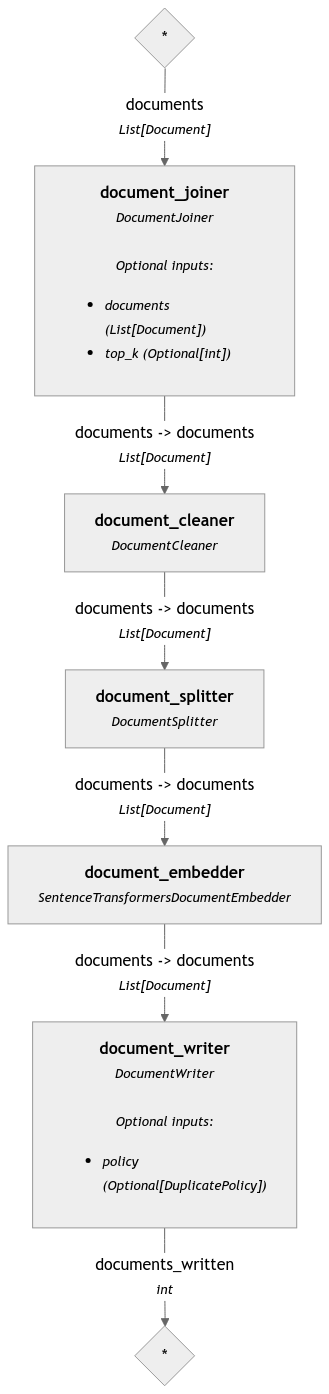

In [99]:
preprocessing_pipeline.run(data = {"document_joiner": { "documents" : ready_list }})
# preprocessing_pipeline.inputs()
preprocessing_pipeline.show()

## Test RAG with Pinecone Document Store

Restart the kernel and run the following code to test the RAG pipeline with the populated Pinecone Document Store.

Create pipeline to run a query

In [5]:
from haystack.components.embedders import SentenceTransformersDocumentEmbedder, SentenceTransformersTextEmbedder
from haystack_integrations.components.retrievers.pinecone import PineconeEmbeddingRetriever
from haystack.components.generators import OpenAIGenerator
from haystack.components.builders.answer_builder import AnswerBuilder
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack import Pipeline
from haystack_integrations.document_stores.pinecone import PineconeDocumentStore
from dotenv import load_dotenv

template = """
    Given these documents, answer the question.\nDocuments:
    {% for doc in documents %}
        {{ doc.content }}
    {% endfor %}

    \nQuestion: {{question}}
    \nAnswer:
"""

load_dotenv()

document_store = PineconeDocumentStore(
    index="default",
    namespace="default",
    dimension=384,
    metric="cosine",
    spec={"serverless": {"region": "us-east-1", "cloud": "aws"}}
)


document_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
text_embedder = SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
retriever = PineconeEmbeddingRetriever(document_store=document_store, top_k=40)
generator = OpenAIGenerator()
answer_builder = AnswerBuilder()
prompt_builder = PromptBuilder(template=template)

rag_pipeline = Pipeline()
rag_pipeline.add_component("text_embedder", text_embedder)
rag_pipeline.add_component("retriever", retriever)
rag_pipeline.add_component("prompt_builder", prompt_builder)
rag_pipeline.add_component("llm", generator)
rag_pipeline.add_component("answer_builder", answer_builder)

rag_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
rag_pipeline.connect("retriever", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder", "llm")
rag_pipeline.connect("llm.replies", "answer_builder.replies")
rag_pipeline.connect("retriever", "answer_builder.documents")

🚅 Components
  - text_embedder: SentenceTransformersTextEmbedder
  - retriever: PineconeEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
  - answer_builder: AnswerBuilder
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - retriever.documents -> answer_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)
  - llm.replies -> answer_builder.replies (List[str])

Run the pipeline with a query

In [8]:
query = "Error: missing libsodium"
result = rag_pipeline.run({
    "text_embedder": {"text": query},
    "prompt_builder": {"question": query},
    "answer_builder": {"query": query}
})

print(result['answer_builder']['answers'][0].query)
print(result['answer_builder']['answers'][0].data)
print(result['answer_builder']['answers'][0].documents)

with open("output.md", "w") as f:
    f.write(result['answer_builder']['answers'][0].data)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Error: missing libsodium
To resolve the error of missing libsodium, the following steps can be taken:

1. Temporarily update the default.nix file to add the test suits dependencies to the library section.
2. If cabal is complaining about a missing libsodium, add sodium-crypt-sign to the shell environment.

This should help resolve the missing libsodium error.
[Document(id=d0d92f1d68460078f9c13b699d9ff44bc264f834d86ead346d71e98bf346009a, content: 'temporarily update thedefault.nixfile (generated bygenerate-local-nix-packages.sh) to add the test s...', meta: {'date': 'None', 'headline': 'Upgrading\uf0c1', 'page_number': 1, 'source_id': 'e5898e5477153888ea545a34c4406d4281eea1e78e2c22f12b37202c8a83bfa3', 'split_id': 5, 'split_idx_start': 6411, 'title': 'Upgrading — Wire 0.0.4 documentation', 'url': 'https://docs.wire.com/developer/developer/upgrading.html'}, score: 0.425638229, embedding: vector of size 384), Document(id=3cdd886c6ddf403482a00631f6c0ea7d0607568e0c4112fafb07f2404df4c1cb, con